# 🩺 Chest X-ray Classification: Normal vs Pneumonia
**Date:** 2025-10-26

This notebook implements an end-to-end deep learning pipeline (PyTorch) to classify chest X-rays as **Normal** or **Pneumonia**.

**Highlights**
- Robust dataset setup: auto-detect common paths or upload a ZIP (Colab)
- ImageFolder loaders with augmentation toggles (none/light/medium/heavy)
- Transfer learning (ResNet50): freeze → fine-tune
- GPU-safe AMP (`torch.amp.autocast('cuda', ...)`) + `GradScaler`
- Early stopping, gradient clipping, checkpointing
- Metrics: Accuracy, Classification Report, Confusion Matrix, ROC/AUC
- Grad-CAM explainability
- Learning Rate Finder (range test) + mini hyperparameter sweep


## 1. Setup & Imports


In [1]:
# If using Colab, consider enabling GPU: Runtime → Change runtime type → GPU
# !nvidia-smi
# !pip install -q torch torchvision scikit-learn matplotlib pillow timm

import os, io, zipfile, time, math, argparse, json, re
from pathlib import Path
from contextlib import nullcontext

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay, precision_recall_fscore_support
)
from PIL import Image

# Device, AMP, and pinned-memory flags
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
PIN_MEM = bool(is_cuda)

def amp_context():
    if is_cuda:
        return torch.amp.autocast(device_type='cuda')
    else:
        return nullcontext()

scaler = torch.cuda.amp.GradScaler(enabled=is_cuda)
print("Device:", device)


Device: cpu


/tmp/ipython-input-3764809020.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=is_cuda)


## 2. Dataset Setup (Auto-detect or Upload ZIP in Colab)


In [2]:
def has_splits(root):
    return root and Path(root, "train").exists() and Path(root, "val").exists() and Path(root, "test").exists()

def setup_dataset(data_root_env=None, allow_colab_upload=True):
    candidates = [
        data_root_env or os.getenv("XRAY_DATA_ROOT"),
        "/mnt/data/xray_data",                 # this workspace
        "/content/xray_data",                  # Colab temp
        "/content/drive/MyDrive/xray_data",    # Colab Drive
    ]
    DATA_ROOT = None
    for p in candidates:
        if has_splits(p):
            DATA_ROOT = p
            break

    if DATA_ROOT is None and allow_colab_upload:
        try:
            from google.colab import files  # works only in Colab
            print("No dataset found. Upload ZIP (e.g., xray_data_structured.zip) when prompted…")
            uploaded = files.upload()
            assert uploaded, "No file uploaded."
            zipname = next(iter(uploaded.keys()))
            target = "/content/xray_data"
            os.makedirs(target, exist_ok=True)
            with zipfile.ZipFile(io.BytesIO(uploaded[zipname]), 'r') as z:
                z.extractall(target)
            # If nested, locate actual split root
            if not has_splits(target):
                for sub in Path(target).glob("*"):
                    if sub.is_dir() and has_splits(str(sub)):
                        target = str(sub)
                        break
            assert has_splits(target), "Uploaded ZIP must contain train/val/test folders."
            DATA_ROOT = target
        except Exception as e:
            raise FileNotFoundError(
                "Dataset not found. Set XRAY_DATA_ROOT to your dataset folder OR upload a zip in Colab."
            ) from e

    assert DATA_ROOT and has_splits(DATA_ROOT), f"Dataset at {DATA_ROOT} is missing train/val/test."
    return DATA_ROOT

DATA_ROOT = setup_dataset()
print("Dataset root:", DATA_ROOT)


No dataset found. Upload ZIP (e.g., xray_data_structured.zip) when prompted…


Saving xray_data_structured.zip to xray_data_structured.zip
Dataset root: /content/xray_data


## 3. Transforms & DataLoaders (with Augmentation Toggles)


In [5]:
# Choose augmentation level: 'none' | 'light' | 'medium' | 'heavy'
AUG_LEVEL = 'medium'  #@param ['none', 'light', 'medium', 'heavy']
IMG_SIZE = 224
BATCH_SIZE = 32

def build_train_transforms(level='medium', img_size=224):
    if level == 'none':
        base = [transforms.Resize((img_size, img_size))]
    elif level == 'light':
        base = [
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
        ]
    elif level == 'medium':
        base = [
            transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
        ]
    else:  # heavy
        base = [
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.RandomErasing(p=0.25),
        ]
    base += [
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]
    return transforms.Compose(base)

def build_eval_transforms(img_size=224):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

def make_loaders(DATA_ROOT, batch_size=32, img_size=224, aug_level='medium'):
    train_tfms = build_train_transforms(aug_level, img_size)
    eval_tfms  = build_eval_transforms(img_size)
    train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_tfms)
    val_ds   = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=eval_tfms)
    test_ds  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=eval_tfms)
    classes = train_ds.classes
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=PIN_MEM)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=PIN_MEM)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=PIN_MEM)
    return train_dl, val_dl, test_dl, classes, train_ds, val_ds, test_ds

train_dl, val_dl, test_dl, CLASSES, train_ds, val_ds, test_ds = make_loaders(DATA_ROOT, BATCH_SIZE, IMG_SIZE, AUG_LEVEL)
assert len(CLASSES) == 2, f"Expected binary dataset; found {len(CLASSES)} classes: {CLASSES}"
print("Classes:", CLASSES)
print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))


Classes: ['normal', 'pneumonia']
Train/Val/Test sizes: 145 32 30


## 4. Utilities: Training Loop, Evaluation, and Plots


In [6]:
def train_one_epoch(model, loader, optimizer, loss_fn, grad_clip=None):
    model.train()
    total, correct, run_loss = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        with amp_context():
            logits = model(xb)
            loss = loss_fn(logits, yb)
        scaler.scale(loss).backward()
        if grad_clip:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        run_loss += loss.item() * xb.size(0)
        total += xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
    return run_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    total, correct, run_loss = 0, 0, 0.0
    probs_all, targets_all = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with amp_context():
            logits = model(xb)
            loss = loss_fn(logits, yb)
        run_loss += loss.item() * xb.size(0)
        total += xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        probs = F.softmax(logits, dim=1)[:,1]
        probs_all.append(probs.detach().cpu().numpy())
        targets_all.append(yb.detach().cpu().numpy())
    y_prob = np.concatenate(probs_all)
    y_true = np.concatenate(targets_all)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float("nan")
    return run_loss/total, correct/total, auc, (y_true, y_prob)

def plot_cm_roc(y_true, y_prob, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (AUC={auc:.3f})"); plt.legend(); plt.show()


## 5. Model: ResNet50 Transfer Learning (Freeze → Fine-tune)


In [7]:
USE_PRETRAINED = True  # set False if offline to avoid weight download
weights = models.ResNet50_Weights.DEFAULT if USE_PRETRAINED else None
model = models.resnet50(weights=weights)
for p in model.parameters(): p.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 69.0MB/s]


## 6. Train Head → Fine-tune (with Early Stopping & Checkpoint)


In [8]:
best_vl = 0.0
patience = 3
wait = 0
ckpt_path = Path("best_resnet50_binary.pt")

# Phase 1: train classifier head
for epoch in range(5):
    tr_loss, tr_acc = train_one_epoch(model, train_dl, opt, loss_fn, grad_clip=1.0)
    vl_loss, vl_acc, vl_auc, _ = evaluate(model, val_dl, loss_fn)
    print(f"[Frozen] Epoch {epoch+1}: tr_acc={tr_acc:.3f} | val_acc={vl_acc:.3f} | val_auc={vl_auc:.3f}")
    if vl_acc > best_vl:
        best_vl = vl_acc; wait = 0; torch.save(model.state_dict(), ckpt_path)
    else:
        wait += 1
        if wait >= patience: break

# Phase 2: unfreeze and fine-tune
for p in model.parameters(): p.requires_grad = True
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
wait = 0
for epoch in range(8):
    tr_loss, tr_acc = train_one_epoch(model, train_dl, opt, loss_fn, grad_clip=1.0)
    vl_loss, vl_acc, vl_auc, _ = evaluate(model, val_dl, loss_fn)
    print(f"[Finetune] Epoch {epoch+1}: tr_acc={tr_acc:.3f} | val_acc={vl_acc:.3f} | val_auc={vl_auc:.3f}")
    if vl_acc > best_vl:
        best_vl = vl_acc; wait = 0; torch.save(model.state_dict(), ckpt_path)
    else:
        wait += 1
        if wait >= patience: break

print("Best validation accuracy:", round(best_vl, 3))


[Frozen] Epoch 1: tr_acc=0.531 | val_acc=0.625 | val_auc=0.692
[Frozen] Epoch 2: tr_acc=0.738 | val_acc=0.656 | val_auc=0.887
[Frozen] Epoch 3: tr_acc=0.869 | val_acc=0.656 | val_auc=0.954
[Frozen] Epoch 4: tr_acc=0.890 | val_acc=0.656 | val_auc=0.963
[Frozen] Epoch 5: tr_acc=0.869 | val_acc=0.688 | val_auc=0.992
[Finetune] Epoch 1: tr_acc=0.952 | val_acc=0.906 | val_auc=1.000
[Finetune] Epoch 2: tr_acc=0.966 | val_acc=0.969 | val_auc=1.000
[Finetune] Epoch 3: tr_acc=0.986 | val_acc=0.938 | val_auc=1.000
[Finetune] Epoch 4: tr_acc=0.993 | val_acc=0.906 | val_auc=1.000
[Finetune] Epoch 5: tr_acc=0.993 | val_acc=0.969 | val_auc=1.000
Best validation accuracy: 0.969


## 7. Test Evaluation & Metrics


Test Accuracy: 1.000 | Test AUC: 1.000

Classification Report (Test):
              precision    recall  f1-score   support

      normal     1.0000    1.0000    1.0000        19
   pneumonia     1.0000    1.0000    1.0000        11

    accuracy                         1.0000        30
   macro avg     1.0000    1.0000    1.0000        30
weighted avg     1.0000    1.0000    1.0000        30



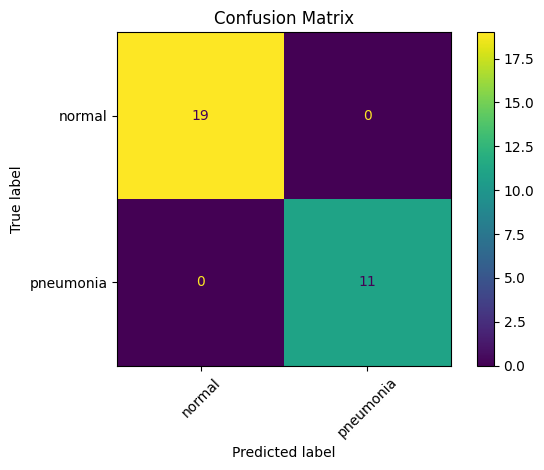

/tmp/ipython-input-3910500837.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.title(f"ROC Curve (AUC={auc:.3f})"); plt.legend(); plt.show()


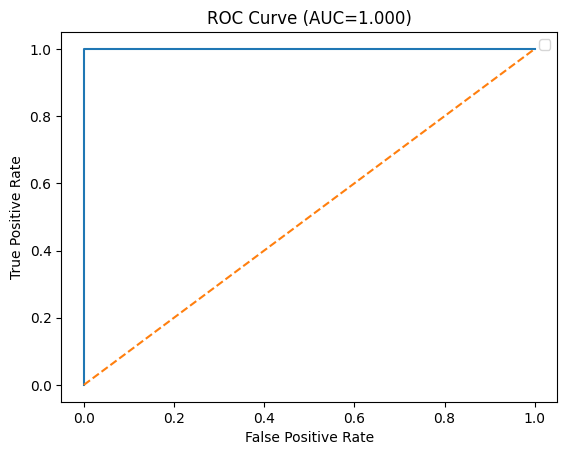

Saved: best_resnet50_binary.pt, class_index.json


In [9]:
# Load best and evaluate on test set
model.load_state_dict(torch.load(ckpt_path, map_location=device))
te_loss, te_acc, te_auc, (y_true, y_prob) = evaluate(model, test_dl, loss_fn)
print(f"Test Accuracy: {te_acc:.3f} | Test AUC: {te_auc:.3f}")

# Predictions and report
model.eval(); y_pred = []
with torch.no_grad():
    for xb, yb in test_dl:
        y_pred.extend(model(xb.to(device)).argmax(1).cpu().numpy())

print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

# Visuals
plot_cm_roc(y_true, y_prob, y_pred, CLASSES)

# Save label map
with open('class_index.json','w') as f:
    json.dump({i:c for i,c in enumerate(CLASSES)}, f, indent=2)
print("Saved: best_resnet50_binary.pt, class_index.json")


## 8. Grad-CAM Explainability


In [10]:
def grad_cam_resnet50(model, pil_image, img_size=224, class_idx=None):
    model.eval()
    tfm = transforms.Compose([transforms.Resize((img_size,img_size)),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    x = tfm(pil_image).unsqueeze(0).to(device)
    target_layer = model.layer4[-1].conv3 if hasattr(model.layer4[-1], 'conv3') else model.layer4[-1].bn3
    feats, grads = [], []
    def f_hook(m,i,o): feats.append(o)
    def b_hook(m,gi,go): grads.append(go[0])
    h1 = target_layer.register_forward_hook(f_hook)
    h2 = target_layer.register_backward_hook(b_hook)
    logits = model(x)
    if class_idx is None:
        class_idx = int(logits.argmax(1).item())
    score = logits[0, class_idx]
    model.zero_grad(); score.backward()
    h1.remove(); h2.remove()
    f = feats[0].detach().cpu().squeeze(0)  # (C,H,W)
    g = grads[0].detach().cpu().squeeze(0)  # (C,H,W)
    w = g.mean(dim=(1,2))
    cam = (w[:,None,None]*f).sum(0)
    cam = torch.clamp(cam, min=0)
    cam = cam / (cam.max() + 1e-8)
    return cam.numpy(), class_idx

# Example usage (uncomment and set a path):
# sample = next((Path(DATA_ROOT)/"test"/CLASSES[0]).glob("*.jpg"), None)
# if sample is None:
#     sample = next((Path(DATA_ROOT)/"test"/CLASSES[0]).glob("*.png"), None)
# img = Image.open(sample).convert("RGB")
# cam, idx = grad_cam_resnet50(model, img, img_size=IMG_SIZE)
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1); plt.imshow(img); plt.axis("off"); plt.title("Original")
# plt.subplot(1,2,2); plt.imshow(img); plt.imshow(cam, alpha=0.45); plt.axis("off"); plt.title(f"Grad-CAM (pred: {CLASSES[idx]})")
# plt.tight_layout(); plt.show()


## 9. Learning Rate Finder (Range Test)


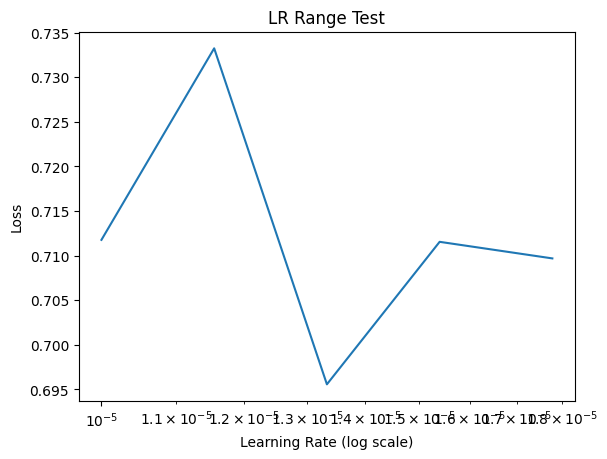

Suggested LR (heuristic): 1.3335214321633243e-06


In [11]:
def lr_range_test(model, train_loader, loss_fn, optimizer, start_lr=1e-5, end_lr=1.0, num_iters=80):
    model.train()
    lrs, losses = [], []
    lr = start_lr
    factor = (end_lr / start_lr) ** (1/num_iters)
    for g in optimizer.param_groups: g['lr'] = lr
    it = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        with amp_context():
            logits = model(xb)
            loss = loss_fn(logits, yb)
        loss.backward(); optimizer.step()
        lrs.append(lr); losses.append(float(loss.item()))
        lr *= factor
        for g in optimizer.param_groups: g['lr'] = lr
        it += 1
        if it >= num_iters:
            break
    return lrs, losses

# Quick LR finder demo (fresh small model for speed)
_tmp = models.resnet18(weights=None)
_tmp.fc = nn.Linear(_tmp.fc.in_features, 2); _tmp = _tmp.to(device)
opt_tmp = torch.optim.SGD(_tmp.parameters(), lr=1e-6, momentum=0.9)
lrs, losses = lr_range_test(_tmp, train_dl, nn.CrossEntropyLoss(), opt_tmp, start_lr=1e-5, end_lr=1.0, num_iters=80)

plt.figure(); plt.plot(lrs, losses); plt.xscale('log')
plt.xlabel("Learning Rate (log scale)"); plt.ylabel("Loss"); plt.title("LR Range Test")
plt.show()

import numpy as np
min_idx = int(np.argmin(losses))
suggested_lr = lrs[min_idx] / 10.0
print("Suggested LR (heuristic):", suggested_lr)


## 10. Mini Hyperparameter Sweep (fast)


In [12]:
from itertools import product
import pandas as pd

GRID = {
    "optimizer": ["adam", "sgd_mom"],
    "lr": [1e-4, 3e-4, 1e-3],
    "weight_decay": [0.0, 1e-4],
    "batch_size": [16, 32],
    "epochs": [2],  # keep it short
}

def build_model_for_sweep(use_pretrained=False):
    weights = models.ResNet18_Weights.DEFAULT if use_pretrained else None
    m = models.resnet18(weights=weights)
    m.fc = nn.Linear(m.fc.in_features, 2)
    return m.to(device)

def get_optimizer(name, params, lr, wd):
    if name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    else:
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)

results = []
for opt_name, lr, wd, bs, epochs in product(GRID["optimizer"], GRID["lr"], GRID["weight_decay"], GRID["batch_size"], GRID["epochs"]):
    BATCH_SIZE = bs
    train_dl, val_dl, test_dl, CLASSES, *_ = make_loaders(DATA_ROOT, BATCH_SIZE, IMG_SIZE, 'light')
    m = build_model_for_sweep(use_pretrained=False)
    opt = get_optimizer(opt_name, m.parameters(), lr, wd)
    lf = nn.CrossEntropyLoss()
    best_v = 0.0; t0 = time.time()
    for ep in range(epochs):
        tr_loss, tr_acc = train_one_epoch(m, train_dl, opt, lf)
        vl_loss, vl_acc, vl_auc, _ = evaluate(m, val_dl, lf)
        best_v = max(best_v, vl_acc)
    dur = time.time()-t0
    results.append({"optimizer": opt_name, "lr": lr, "weight_decay": wd, "batch_size": bs,
                    "epochs": epochs, "val_acc": float(best_v), "time_s": round(dur,1)})
    print(results[-1])

df = pd.DataFrame(results).sort_values("val_acc", ascending=False).reset_index(drop=True)
df


{'optimizer': 'adam', 'lr': 0.0001, 'weight_decay': 0.0, 'batch_size': 16, 'epochs': 2, 'val_acc': 0.4375, 'time_s': 89.5}
{'optimizer': 'adam', 'lr': 0.0001, 'weight_decay': 0.0, 'batch_size': 32, 'epochs': 2, 'val_acc': 0.78125, 'time_s': 89.8}
{'optimizer': 'adam', 'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 16, 'epochs': 2, 'val_acc': 0.5625, 'time_s': 84.4}
{'optimizer': 'adam', 'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 32, 'epochs': 2, 'val_acc': 0.46875, 'time_s': 87.5}
{'optimizer': 'adam', 'lr': 0.0003, 'weight_decay': 0.0, 'batch_size': 16, 'epochs': 2, 'val_acc': 0.9375, 'time_s': 84.0}
{'optimizer': 'adam', 'lr': 0.0003, 'weight_decay': 0.0, 'batch_size': 32, 'epochs': 2, 'val_acc': 0.65625, 'time_s': 88.0}
{'optimizer': 'adam', 'lr': 0.0003, 'weight_decay': 0.0001, 'batch_size': 16, 'epochs': 2, 'val_acc': 0.71875, 'time_s': 87.7}
{'optimizer': 'adam', 'lr': 0.0003, 'weight_decay': 0.0001, 'batch_size': 32, 'epochs': 2, 'val_acc': 0.875, 'time_s': 88.4}
{

,optimizer,lr,weight_decay,batch_size,epochs,val_acc,time_s
0,adam,0.0003,0.0000,16,2,0.93750,84.0
1,adam,0.0010,0.0000,16,2,0.90625,83.9
2,adam,0.0003,0.0001,32,2,0.87500,88.4
3,adam,0.0001,0.0000,32,2,0.78125,89.8
4,adam,0.0010,0.0001,16,2,0.78125,84.3
5,sgd_mom,0.0010,0.0001,16,2,0.75000,83.3
6,adam,0.0010,0.0001,32,2,0.71875,87.5
7,adam,0.0003,0.0001,16,2,0.71875,87.7
8,sgd_mom,0.0001,0.0000,16,2,0.71875,83.1
9,adam,0.0003,0.0000,32,2,0.65625,88.0


In [14]:
from PIL import Image
import torch, json
from torchvision import transforms, models
import torch.nn as nn

img_path = "/content/Viral Pneumonia-797.png"

# load class map
with open('class_index.json','r') as f:
    idx2class = {int(k):v for k,v in json.load(f).items()}

# build the same model head and load best weights
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("best_resnet50_binary.pt", map_location="cpu"), strict=False)
model.eval()

# same eval transforms as notebook
IMG_SIZE = 224
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

img = Image.open(img_path).convert("RGB")
x = tfm(img).unsqueeze(0)   # (1,3,H,W)
with torch.no_grad():
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(torch.argmax(probs).item())
    pred_class = idx2class[pred_idx]
    prob = float(probs[pred_idx].item())

print({"pred_class": pred_class, "probability": round(prob, 4)})

{'pred_class': 'pneumonia', 'probability': 0.9392}
